# Embedding multiple networks

Often, we are interested in more than one network. Sometimes this arises from thinking
about multiple "layers," where each layer represents a different kind of relationship.

```{figure} ./images/stacked-adj.png
Example of a multiple-layered network (multigraph) from the *Drosophila* larva brain 
connectome.
```

Or, we may have networks which arise from the same process, but at different timepoints. 

Regardless of the data, it is common to want to:
- Compare the role/structure of each node across networks, or
- Generate a single embedding which summarizes the property of each node, regardless
of which network it came from, or
- Quantitatively compare the networks themselves

Each of these tasks (and many others) can benefit from doing network embeddings which
somehow deal with multiple networks. We'll discuss a few approaches and considerations
below, mainly for the spectral methods. 

```{note}
Many other approaches for doing multiple network embeddings exist, including for some of the
neural network approaches.
```


## Do a couple of spectral embeddings

Let's say we have two networks. We wish to come up with an embedding for *each node
in each network*. Since we've already learned about techniques for network embedding, 
why not just apply these techniques separately to each network, and compare the results?

In [50]:
import networkx as nx
import pandas as pd
from pathlib import Path
from graspologic.utils import symmetrize


DATA_PATH = Path("networks-course/data")


def load_matched(side="left"):
    side = side.lower()
    dir = DATA_PATH / "processed_maggot"
    g = nx.read_edgelist(
        dir / f"matched_{side}_edgelist.csv",
        create_using=nx.DiGraph,
        delimiter=",",
        nodetype=int,
    )
    nodes = pd.read_csv(dir / f"matched_{side}_nodes.csv", index_col=0)
    adj = nx.to_numpy_array(g, nodelist=nodes.index)
    return adj, nodes


left_adj, left_nodes = load_matched("left")
right_adj, right_nodes = load_matched("right")
left_adj = symmetrize(left_adj)
right_adj = symmetrize(right_adj)

In [51]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed(n_components=8)
X_left = ase.fit_transform(left_adj)
X_right = ase.fit_transform(right_adj)

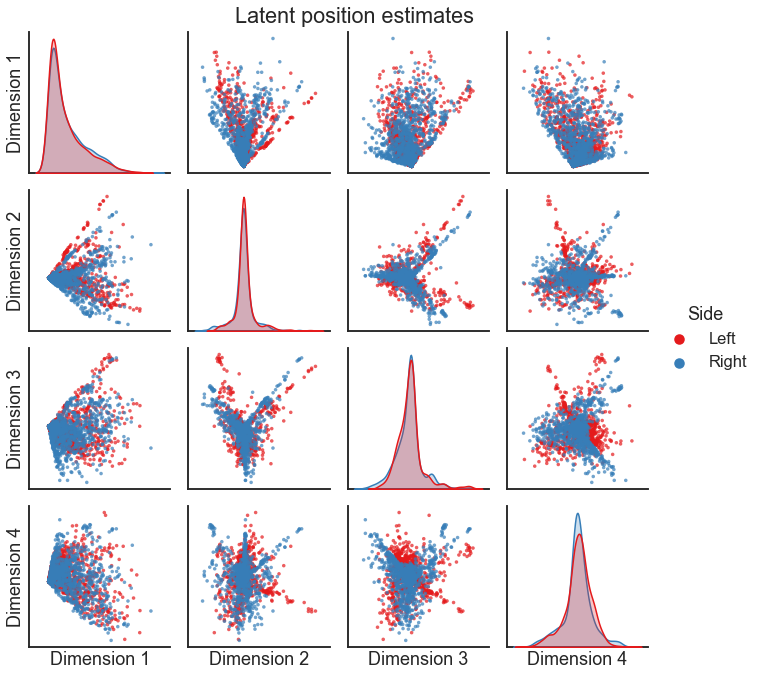

In [52]:
import numpy as np
from graspologic.plot import pairplot

X_both = np.concatenate((X_left, X_right), axis=0)
labels = np.array(len(X_left) * ["Left"] + len(X_right) * ["Right"])

pairplot(X_both[:, :4], labels, legend_name="Side", title="Latent position estimates")

```{admonition} Question
:class: tip

Based on this plot, would you say that these networks are similar? Why or why not?

Do you notice anything about the relationship of one embedding with regard to the 
other? 
```

### Orthogonal nonidentifiability

Earlier in the course, we discussed a model with a nonidentifiability in its parameters.
As a reminder, this just means that we have some flexibility in the parameters we use
which gives us the same model behavior. Can this arise for the RDPG model, which is the
motivation behind doing ASE? Let's have a look. 

Remember that for the RDPG, we are using the model of $A$ being sampled from a
probability matrix, $P$. $P$ has the structure

$$P = XX^T$$

for an undirected network, or for a directed network, 

$$P = XY^T$$

How can a nonidentifiability pop up here? Note that an [**orthogonal matrix**](https://en.wikipedia.org/wiki/Orthogonal_matrix) $W$ is one 
such that

$$W W^T = W^T W = I$$

Intuitively, these orthogonal matrices represent *rotations* and *reflections* in our 
$d$-dimensional space. They are often called **isometric** transformations of the space,
because they *preserve all interpoint distances*.

Text(0.5, 1.0, 'Transformed positions ($X W$)')

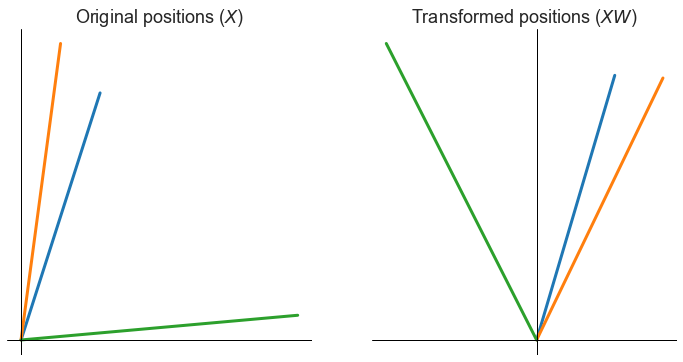

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

X = np.array([[0.2, 0.5], [0.1, 0.6], [0.7, 0.05]])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
for row in X:
    ax.plot([0.0, row[0]], [0.0, row[1]], linewidth=3)

ax.axis("off")
ax.axvline(0, color="black", linewidth=1)
ax.axhline(0, color="black", linewidth=1)
ax.set_title(r"Original positions ($X$)")

from scipy.stats import ortho_group

np.random.seed(888)
W = ortho_group.rvs(2)

Z = X @ W

ax = axs[1]
for row in Z:
    ax.plot([0.0, row[0]], [0.0, row[1]], linewidth=3)

ax.axis("off")
ax.axvline(0, color="black", linewidth=1)
ax.axhline(0, color="black", linewidth=1)
ax.set_title(r"Transformed positions ($X W$)")

Note that the distances between all points is preserved.

```{admonition} Question
:class: tip

Can you think of another set of latent positions, say $Z$, such that or probability
matrix $P = XX^T = ZZ^T$, but $Z \neq X$? 

Hint: where can you insert some orthogonal matrices into the formula $P = XX^T$ such 
that the matrix $P$ is unchanged?
```


Note what this means for our embeddings:

In [54]:
W = ortho_group.rvs(X_left.shape[1])
X_left_new = X_left @ W
P1 = X_left @ X_left.T
P2 = X_left_new @ X_left_new.T

np.isclose(P1, P2).all()

True

We have just found two sets of latent positions which are equally valid - but note that
there are an *infinite* number of orthogonal transformations. 

### Orthogonal procrustes problem

In practice, how can we resolve this issue? Let's say we have these two sets of latent
positions, $X^{(1)}$ and $X^{(2)} W$, and want to somehow compare them on equal footing.
What we can do is try to 
uncover a orthogonal transformation of one set of latent positions with regard to the
other, e.g.

$$X^{(1)} \text{ vs. } X^{(2)} W$$

for some $W$.

```{admonition} Question
What would be a good way to measure the distance between $X^{(1)}$ and $X^{(2)} W$?
```

We arrive at the problem

$$\min_{W: WW^T=W^TW=I} \|X^{(1)} - X^{(2)} W\|_F$$

This is a very old and famous problem known as the [**orthogonal Procrustes problem**](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem), 
and it has an exact solution (fun fact: the solution uses the SVD).

We can apply the Procrustes solution using [`scipy.linalg.orthogonal_procrustes`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html) or a wrapper in `graspologic`, the [`OrthogonalProcrustes`](https://microsoft.github.io/graspologic/latest/reference/reference/align.html#orthogonal-procrustes) class.

In [55]:
from graspologic.align import OrthogonalProcrustes

op = OrthogonalProcrustes()
X_right_pred = op.fit_transform(X_right, X_left)

In [69]:
X_both = np.concatenate((X_left, X_right_pred), axis=0)

pairplot(
    X_both[:, :4],
    labels,
    legend_name="Side",
    title="Latent position estimates (mapped)",
)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 8

```{admonition} Question
:class: tip 

Looking at these embeddings, would you say these networks are similar or different, at 
least at a high level? 
```

### Considerations

```{admonition} Question
Does the order of nodes in $X^{(2)}$ matter? What does it represent?
```

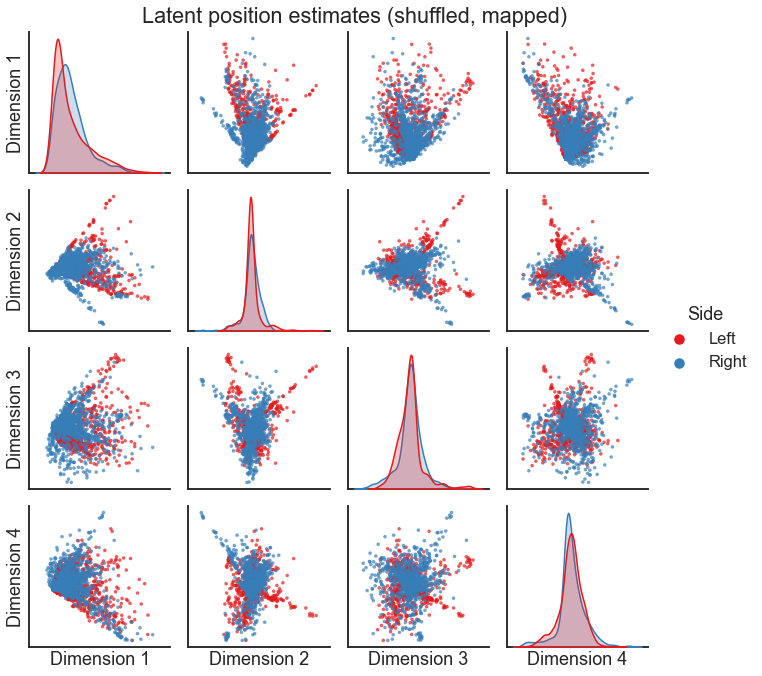

In [57]:
rng = np.random.default_rng(88)
perm_inds = rng.permutation(len(X_right))
op = OrthogonalProcrustes()
X_right_pred = op.fit_transform(X_right[perm_inds], X_left)

X_both = np.concatenate((X_left, X_right_pred), axis=0)

pairplot(
    X_both[:, :4],
    labels,
    legend_name="Side",
    title="Latent position estimates (shuffled, mapped)",
)

```{note}
The orthogonal Procrustes solution only works for pairs of networks where we *know* the
mapping between node $i$, graph 1 and node $i$, graph 2. As a consequence, this would
only work if the networks have the same size.

Note that we can use something called [`SeedlessProcrustes`](https://microsoft.github.io/graspologic/latest/reference/reference/align.html#seedless-procrustes) in `graspologic` if we had two networks of different sizes or
where the mapping between nodes is unknown. There is more information about this method, 
as well as alignments in general, in the [`align` tutorials](https://microsoft.github.io/graspologic/latest/tutorials/aligning/aligning.html).
```

```{warning}
The dimensionality of the embedding can have a huge effect on the quality of the 
alignment (for reasons I won't go into here, but talk about in a forthcoming paper). I
always recommend that you try a range of dimensionalities, and *look at the embeddings*
after aligning them.
```

## Omnibus Embedding

The method described above (basically just doing ASE twice) is a totally valid way of
attacking this multiple network embedding problem, though it has many caveats. In 
practice, we often want to do multiple network embeddings without dealing with this 
alignment issue. For matched networks, we can use a technique called the Omnibus
embedding (Omni, for short).

The algorithm itself is pretty simple. We essentially construct a larger matrix
(described in the figure below) which is constructed from each of the individual
adjacency matrices. We then decompose that larger matrix $M$ using the same process as 
ASE. Because this embedding is done in one stage (rather than one for each network) we
no longer have the same issue with the nonidentifiability above, so we no longer have 
to worry about aligning our embeddings between networks. 

```{figure} ./images/omni.png

Construction of the matrix $M$ which is then decomposed using the SVD in the Omnibus
embedding. Figure from {cite:t}`athreya2017statistical`.
```

In [58]:
from graspologic.embed import OmnibusEmbed

omni = OmnibusEmbed(n_components=4)
X_left, X_right = omni.fit_transform([left_adj, right_adj])

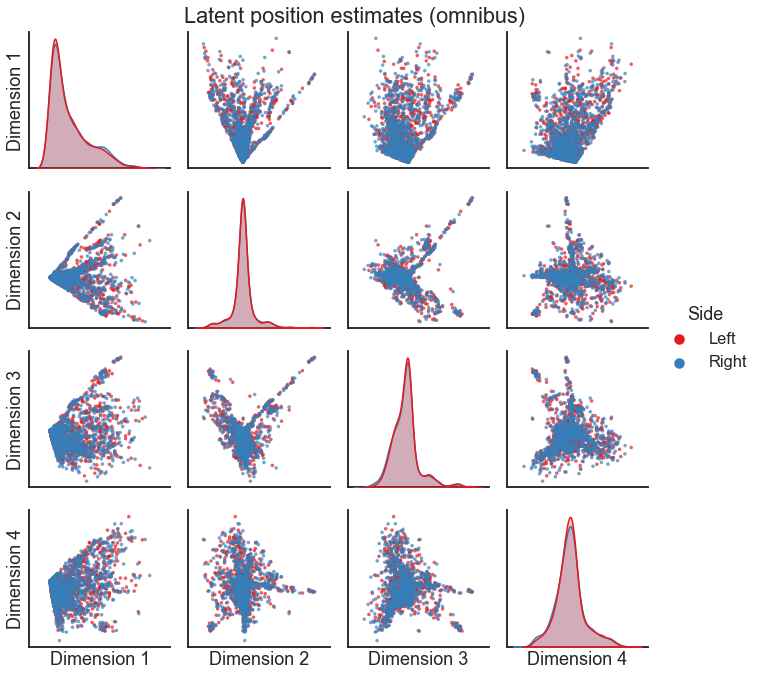

In [59]:
X_both = np.concatenate((X_left, X_right), axis=0)

pairplot(
    X_both, labels, legend_name="Side", title="Latent position estimates (omnibus)"
)

## Multiple ASE

Sometimes, we aren't as interested in having a representation for each node in each 
graph - perhaps we don't care about what is different between networks, and we are
interested in grouping nodes based on their *shared* structure across many different
networks. An algorithm called **multiple adjacency spectral embedding (MASE)** introduced 
in {cite:t}`arroyo2021inference` can be used for this task. 

I won't go into all the details of the algorithm, though I believe you all could
understand it based on what we've talked about in this course. However, I'll say that
this algorithm is associated with a model, where we model the probability matrix for
graph $k$ as

$$P^{(k)} = V R^{(k)} V^T$$

Note that there is no superscript on the $V$ - these are node-wise representations
which are *shared* across all of the networks. You can think of this as one embedding
for each node in the network, but we got it using all of the networks to form this 
representation. The $R^{(k)}$ matrices, sometimes called
the "score" matrices, are able of representing how each network is (potentially)
different.

Using MASE is easy in `graspologic`. Here, we apply it to form a latent position
estimate for each node pair

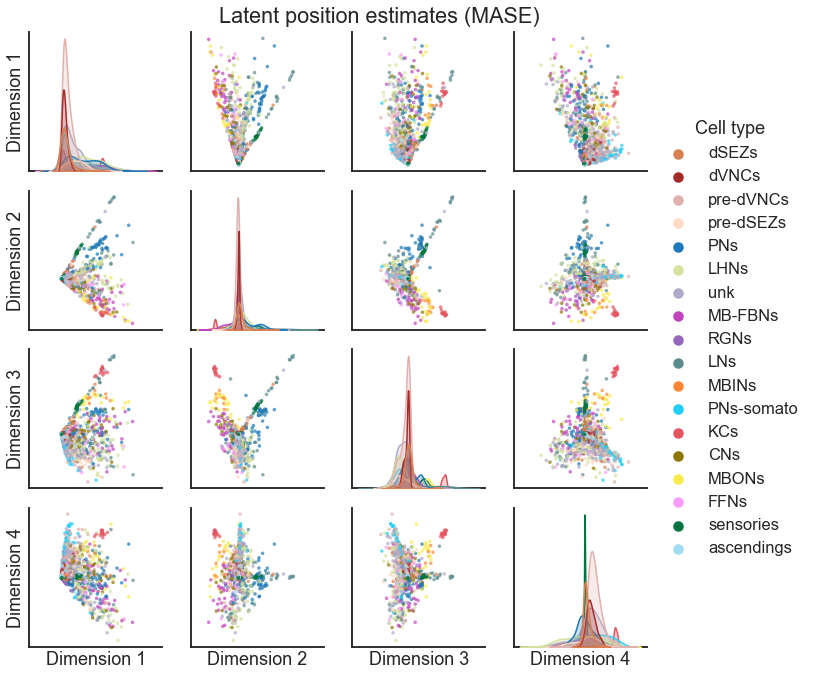

In [60]:
import json
from graspologic.embed import MultipleASE

with open(DATA_PATH / "processed_maggot/simple_color_map.json", "r") as f:
    palette = json.load(f)

mase = MultipleASE(n_components=4)
X_joint = mase.fit_transform([left_adj, right_adj])

node_labels = left_nodes["simple_group"].values

pairplot(
    X_joint,
    node_labels,
    legend_name="Cell type",
    title="Latent position estimates (MASE)",
    palette=palette,
)

```{note} 
The MASE algorithm also has a method for extracting a representation per *network*. In
`graspologic`, these can be accessed using the `.score_` attribute of the fitted object.
More details can be found in the [MASE tutorial](https://microsoft.github.io/graspologic/latest/tutorials/embedding/MASE.html).
```

```{figure} ./images/mase-brain.png

Example of extracting a per-graph representation from the MASE algorithm. Figure from 
{cite:t}`arroyo2021inference`.
```

## Representations for each network

The following example comes from the `graspologic` [tutorial on multiscale comparative connectomics](https://microsoft.github.io/graspologic/latest/tutorials/connectomics/mcc.html), which is based on {cite:t}`gopalakrishnan2020multiscale`. 
The data comes from {cite:t}`wang2020variability`.

Below, we load in 32 networks - these networks come from MRI scans of mice brains, and 
these mouse came from one of 4 different genotypes. There are 8 mice from each genotype.

In [61]:
from graspologic.datasets import load_mice

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
graphs.shape

(32, 332, 332)

As before, we can use the Omnibus embedding to construct an embedding for each network
in the same space, without having to do any alignment.

```{note}
You could absolutely try doing this step with any of the other embedding methods that
we talked about!
```

In [62]:
# Jointly embed graphs using omnibus embedding
embedder = OmnibusEmbed(n_elbows=3)
omni_embedding = embedder.fit_transform(graphs)
print(omni_embedding.shape)

(32, 332, 9)


Now, we have an embedding for each node in each network, and we know that these nodes
are *matched* across networks. To measure the difference between two networks, then, 
we can do something like

$$d(k, l) = \|X^{(k)} - X^{(l)}\|_F$$

Now, we can do this for each $(k, l)$ pair of networks, and create a distance matrix, 
$D$.

$$D_{kl} = d(k, l)$$

In [63]:
dissimilarity_matrix = np.zeros((len(graphs), len(graphs)))

# note: this is a slow way of doing this, but also the most clear to understand.
for i, embedding1 in enumerate(omni_embedding):
    for j, embedding2 in enumerate(omni_embedding):
        dist = np.linalg.norm(embedding1 - embedding2, ord="fro")
        dissimilarity_matrix[i, j] = dist

What does this matrix of dissimilarities look like?

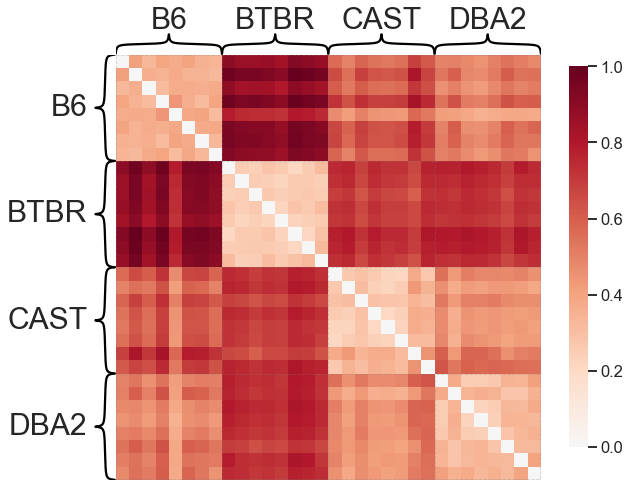

In [64]:
scaled_dissimilarity = dissimilarity_matrix / np.max(dissimilarity_matrix)

_ = heatmap(scaled_dissimilarity, context="talk", inner_hier_labels=mice.labels)

A technique called [**classical multidimensional scaling**](https://en.wikipedia.org/wiki/Multidimensional_scaling#Classical_multidimensional_scaling)
can be used to embed a matrix of distances or dissimilarities, much like we have been 
discussing the embedding of networks. 

In `graspologic`, the `ClassicalMDS` class can operate on a dissimilarity matrix
directly as we do below using the `dissimilarity='precomputed'` flag. You can also
directly pass in `omni_embedding`, if you wanted.

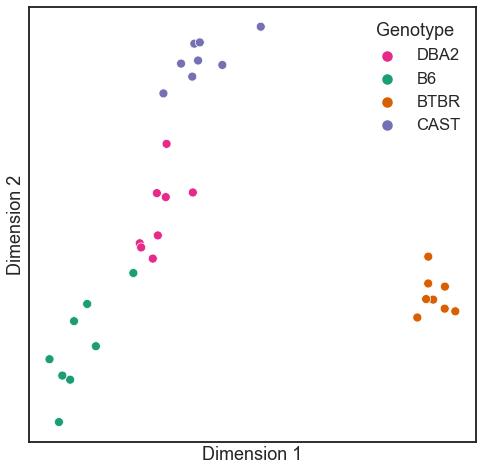

In [67]:
from graspologic.embed import ClassicalMDS
from graspologic.plot import heatmap

# Further reduce embedding dimensionality using cMDS
cmds = ClassicalMDS(n_components=2, dissimilarity="precomputed")
cmds_embedding = cmds.fit_transform(scaled_dissimilarity)
cmds_embedding = pd.DataFrame(cmds_embedding, columns=["Dimension 1", "Dimension 2"])
cmds_embedding["Genotype"] = mice.labels

palette = {"DBA2": "#e7298a", "B6": "#1b9e77", "BTBR": "#d95f02", "CAST": "#7570b3"}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    x="Dimension 1",
    y="Dimension 2",
    hue="Genotype",
    data=cmds_embedding,
    palette=palette,
    ax=ax,
)
ax.set_xticks([])
_ = ax.set_yticks([])

What if we hadn't known the genotype labels ahead of time, and wanted to cluster the 
networks into meaningful groups? We can just run your favorite clustering algorithm,
either on the set of points learned by classical multidimensional scaling, or by
clustering directly on the dissimilarity matrix as I do below.

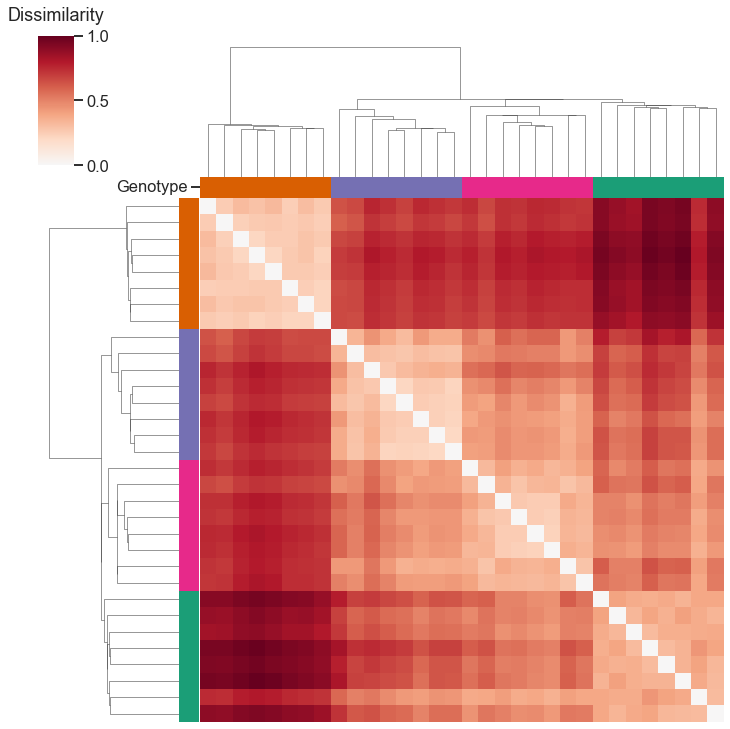

In [68]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

Z = hierarchy.linkage(squareform(scaled_dissimilarity), method="single")

network_colors = np.vectorize(palette.get)(mice.labels)

clustergrid = sns.clustermap(
    scaled_dissimilarity,
    row_linkage=Z,
    col_linkage=Z,
    row_colors=network_colors,
    col_colors=network_colors,
    cmap="RdBu_r",
    center=0,
    xticklabels=False,
    yticklabels=False,
)

# label the colorbar
clustergrid.ax_cbar.set_title("Dissimilarity", pad=15)

# label one of the object color labels
col_ax = clustergrid.ax_col_colors
col_ax.set_yticks([0.5])
_ = col_ax.set_yticklabels(["Genotype"], va="center")

With this representation that we learned from our network embeddings, our clustering
exactly recovered the genotype labels!

## References 
```{bibliography}
:filter: docname in docnames
:style: unsrt
```